In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## References
https://www.kaggle.com/code/amirrezaeian/time-series-data-analysis-using-lstm-tutorial <br>
https://www.kaggle.com/code/tartakovsky/pytorch-lightning-lstm-timeseries-clean-code

In [ ]:
import numpy as np
import pandas as pandas
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define the path to the dataset
dataset_path = "/content/drive/MyDrive/Deep Learning/DL_ops_A2/household_power_consumption.txt"

# Load the dataset
df = pd.read_csv(
    dataset_path,
    sep=";",
    parse_dates={"dt": ["Date", "Time"]},
    infer_datetime_format=True,
    low_memory=False,
    na_values=["nan", "?"],
    index_col="dt",
)

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [ ]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
droping_list_all = []
for j in range(7):
    if df.iloc[:, j].isnull().any():
        droping_list_all.append(j)
        df.iloc[:, j].fillna(df.iloc[:, j].mean(), inplace=True)


In [ ]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

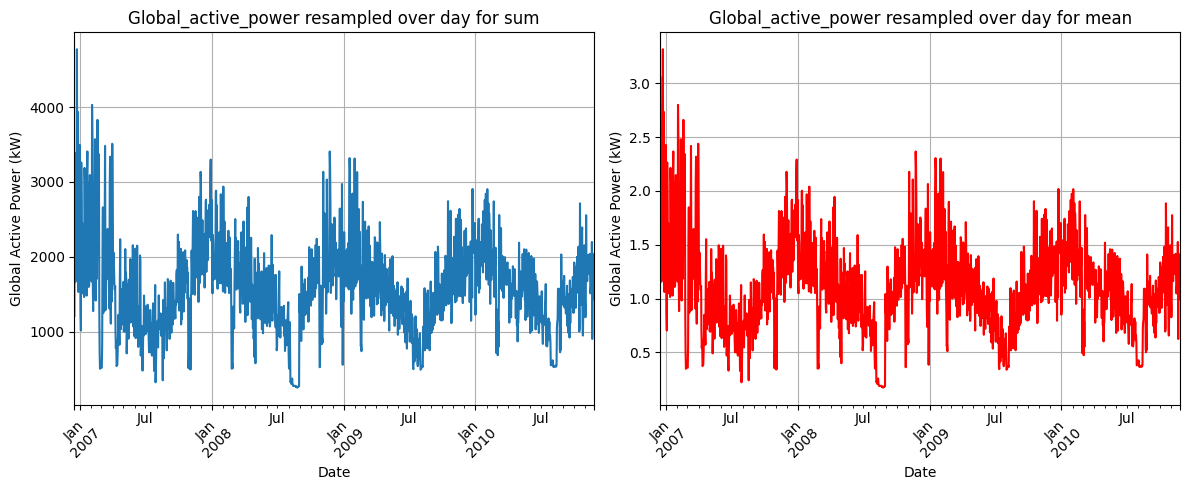

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

df.Global_active_power.resample('D').sum().plot(ax=ax[0], title='Global_active_power resampled over day for sum')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Global Active Power (kW)')
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].grid(True)

df.Global_active_power.resample('D').mean().plot(ax=ax[1], title='Global_active_power resampled over day for mean', color='red')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Global Active Power (kW)')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    if isinstance(data, pd.DataFrame):
        n_vars = data.shape[1]
    elif isinstance(data, np.ndarray):
        n_vars = data.shape[2]
    else:
        raise ValueError('Invalid input type. Must be a pandas DataFrame or numpy array.')

    df = pd.DataFrame(data)
    columns = df.columns

    # Input sequence (t-n, ..., t-1)
    input_cols = []
    for i in range(n_in, 0, -1):
        input_cols.append(df.shift(i).add_suffix(f"_(t-{i})"))

    # Forecast sequence (t, t+1, ..., t+n)
    output_cols = []
    for i in range(n_out):
        if i == 0:
            output_cols.append(df.add_suffix("_t"))
        else:
            output_cols.append(df.shift(-i).add_suffix(f"_(t+{i})"))

    # Combine input and output columns
    cols = pd.concat(input_cols + output_cols, axis=1)

    # Drop rows with NaN values
    if dropnan:
        cols.dropna(inplace=True)

    return cols

In [ ]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [ ]:
df_resample.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [ ]:
values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)


In [ ]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34584,0.146652,0.278476,0.560980,0.147298,0.0,0.020459,0.000000,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061
34585,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000
34586,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000
34587,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000,0.161531,0.078993,0.520246,0.158178,0.0,0.022972,0.000000


In [ ]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


## TTS of 80:20 split run

In [ ]:
y=reframed['var1(t)']
X=reframed.drop(['var1(t)'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (27670, 7)
y_train.shape:  (27670,)
X_test.shape:  (6918, 7)
y_test.shape:  (6918,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(type(X_train), type(y_train), type(X_test), type(y_test))

(27670, 1, 7) (27670,) (6918, 1, 7) (6918,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, 64)
        self.linear2 = nn.Linear(64, output_dim)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout(out)
        out, _ = self.lstm2(out)
        out = nn.functional.relu(self.linear1(out[:, -1, :]))
        out = self.linear2(out)
        return out



In [ ]:
# Instantiate the model
input_dim = X_train.shape[2]
hidden_dim = 100
output_dim = 1
model = LSTM(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-5)



In [ ]:
# Convert data to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train.values).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test.values).float()

In [ ]:
print(input_dim)

7


In [ ]:
import torch
import torch.utils.data

def train(model, criterion, optimizer, X_train, y_train, num_epochs=10, batch_size=64):
    # Create DataLoader for training data
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Train the model
    history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    return history


In [ ]:
# Train the model
history = train(model, criterion, optimizer, X_train, y_train, 10, 64)

Epoch [1/10], Loss: 0.0242
Epoch [2/10], Loss: 0.0133
Epoch [3/10], Loss: 0.0120
Epoch [4/10], Loss: 0.0105
Epoch [5/10], Loss: 0.0076
Epoch [6/10], Loss: 0.0063
Epoch [7/10], Loss: 0.0061
Epoch [8/10], Loss: 0.0058
Epoch [9/10], Loss: 0.0057
Epoch [10/10], Loss: 0.0055


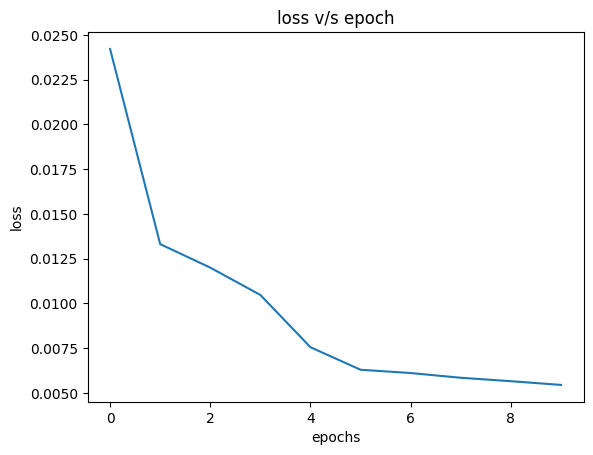

In [ ]:
plt.plot(history)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss v/s epoch')
plt.show()

In [ ]:
print(type(X_train), type(y_train), type(X_test), type(y_test))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [ ]:
import matplotlib.pyplot as plt

# Make predictions
with torch.no_grad():
    test_preds = model(X_test)

# Convert predictions and true values back to numpy arrays
test_preds = test_preds.numpy().flatten()
y_test = y_test.numpy()

rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.105


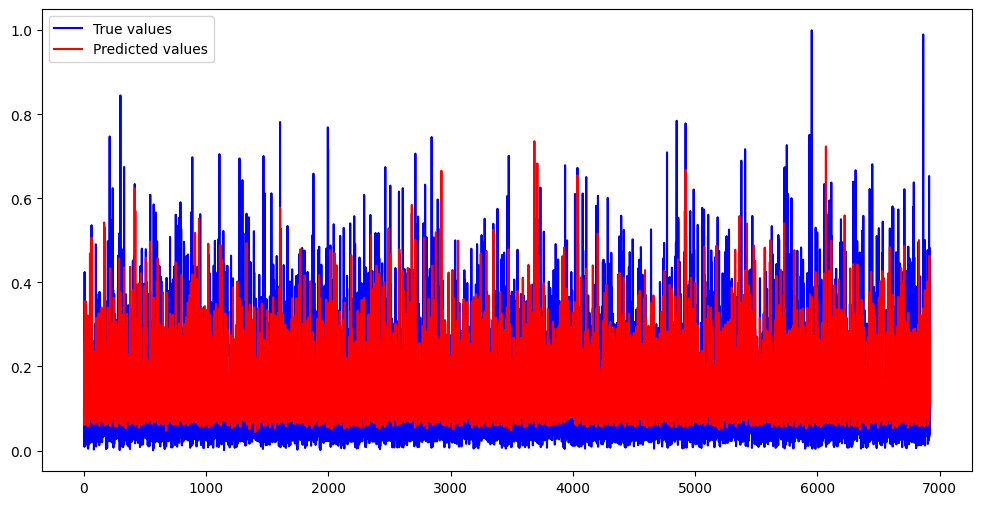

In [ ]:
# Plot predicted values against true values
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b-', label='True values')
plt.plot(test_preds, 'r-', label='Predicted values')
plt.legend()
plt.show()

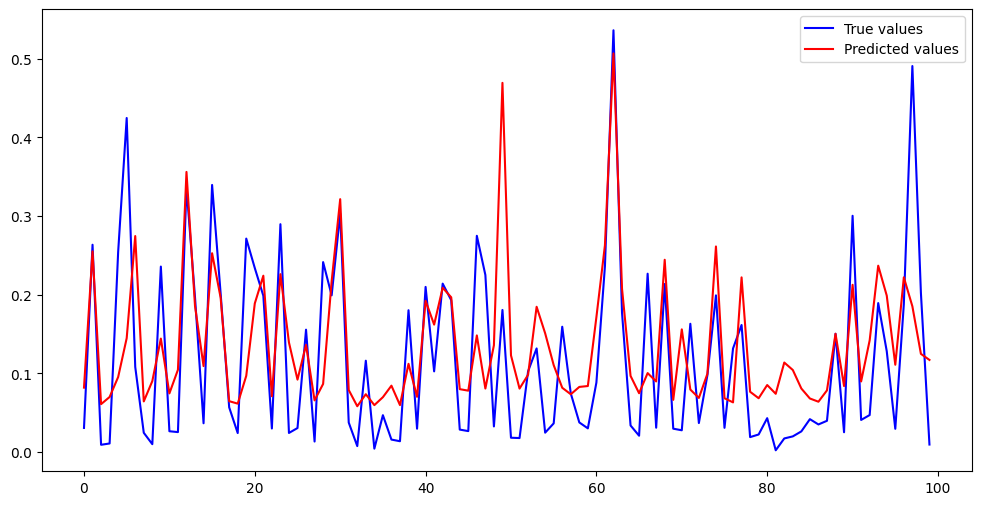

In [ ]:
# Plot predicted values against true values
plt.figure(figsize=(12,6))
plt.plot(y_test[:100], 'b-',label='True values')
plt.plot(test_preds[:100],'r-', label='Predicted values')
plt.legend()
plt.show()

## TTS of 70:30 run

In [ ]:
y=reframed['var1(t)']
X=reframed.drop(['var1(t)'], axis=1)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.3)

In [ ]:
print("X_train.shape: ", X_train_new.shape)
print("y_train.shape: ", y_train_new.shape)

print("X_test.shape: ", X_test_new.shape)
print("y_test.shape: ", y_test_new.shape)

X_train.shape:  (24211, 7)
y_train.shape:  (24211,)
X_test.shape:  (10377, 7)
y_test.shape:  (10377,)


In [ ]:

# reshape input to be 3D [samples, time steps, features]
X_train_new = np.expand_dims(X_train_new.values, axis=1)
X_test_new = np.expand_dims(X_test_new.values, axis=1)
print(X_train_new.shape, y_train_new.shape, X_test_new.shape, y_test_new.shape)
print(type(X_train_new), type(y_train_new), type(X_test_new), type(y_test_new))

(24211, 1, 7) (24211,) (10377, 1, 7) (10377,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [ ]:
# Instantiate the model
input_dim = X_train_new.shape[2]
hidden_dim = 100
output_dim = 1
model2 = LSTM(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 3e-5)

In [ ]:
# Convert data to tensors
X_train_new = torch.from_numpy(X_train_new).float()
y_train_new = torch.from_numpy(y_train_new.values).float()
X_test_new = torch.from_numpy(X_test_new).float()
y_test_new = torch.from_numpy(y_test_new.values).float()

In [ ]:
# Train the model2
num_epochs = 10
batch_size = 64
history2 = train(model2, criterion, optimizer, X_train_new, y_train_new, num_epochs, batch_size)

Epoch [1/10], Loss: 0.0230
Epoch [2/10], Loss: 0.0209
Epoch [3/10], Loss: 0.0184
Epoch [4/10], Loss: 0.0162
Epoch [5/10], Loss: 0.0149
Epoch [6/10], Loss: 0.0153
Epoch [7/10], Loss: 0.0145
Epoch [8/10], Loss: 0.0153
Epoch [9/10], Loss: 0.0145
Epoch [10/10], Loss: 0.0128


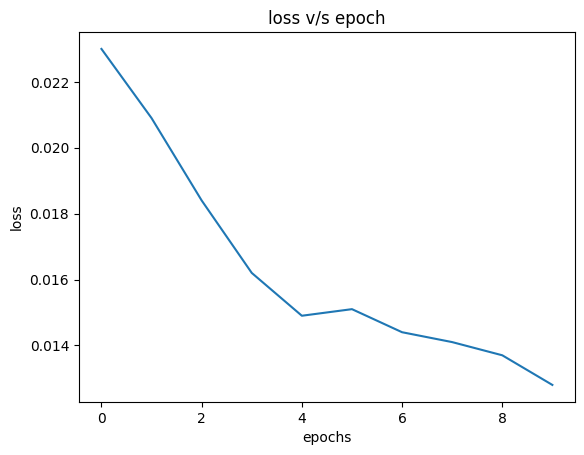

In [ ]:
plt.plot(history2)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss v/s epoch')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
with torch.no_grad():
    test_preds_new = model2(X_test_new)

# Convert predictions and true values back to numpy arrays
test_preds_new = test_preds_new.numpy().flatten()
y_test_new = y_test_new.numpy()

rmse = np.sqrt(mean_squared_error(y_test_new, test_preds_new))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.101


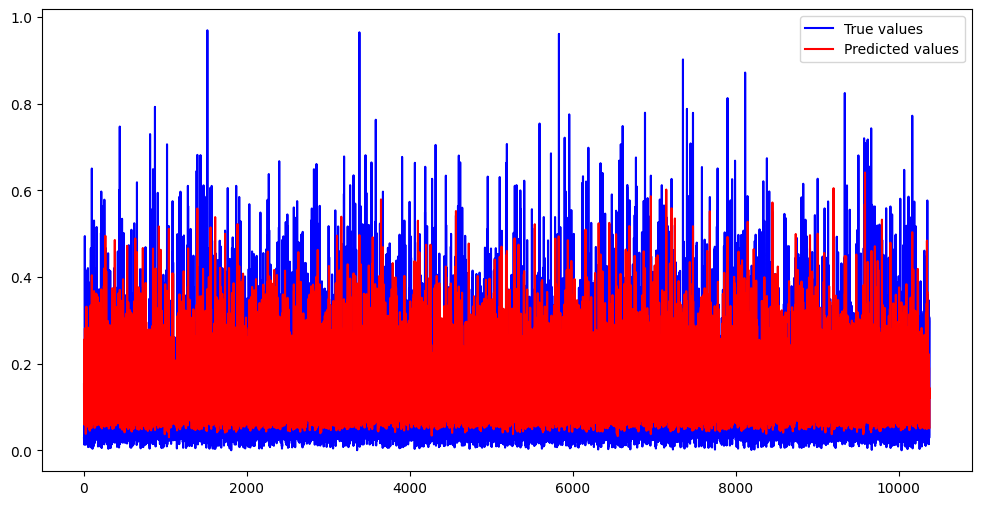

In [ ]:
# Plot predicted values against true values
plt.figure(figsize=(12,6))
plt.plot(y_test_new, 'b-', label='True values')
plt.plot(test_preds_new, 'r-', label='Predicted values')
plt.legend()
plt.show()

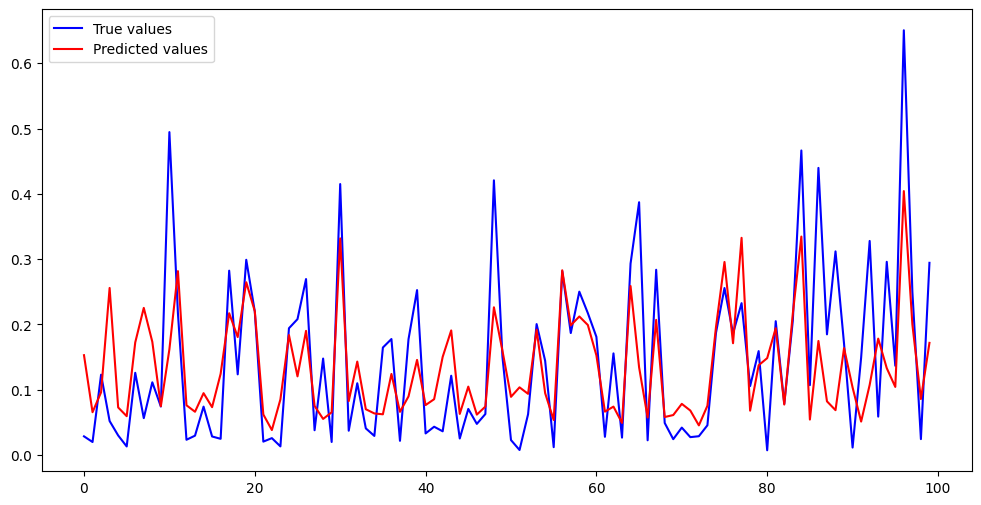

In [ ]:
# Plot predicted values against true values
plt.figure(figsize=(12,6))
plt.plot(y_test_new[:100], 'b-',label='True values')
plt.plot(test_preds_new[:100],'r-', label='Predicted values')
plt.legend()
plt.show()

## comparitive plots

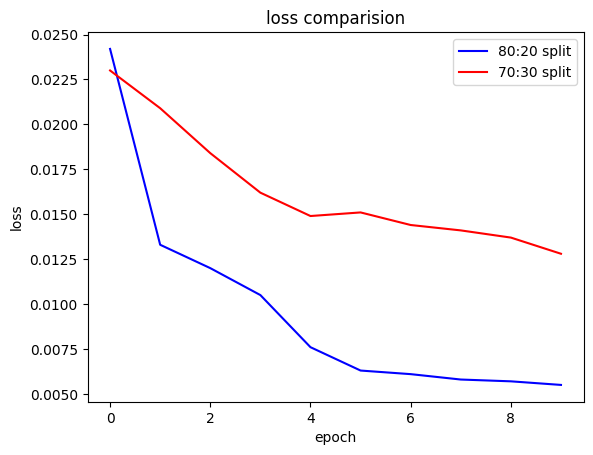

In [ ]:
plt.plot(history, 'b-', label='80:20 split')
plt.plot(history2, 'r-', label = '70:30 split')
plt.legend()
plt.title('loss comparision')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()